# Data Processing

In [97]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import entropy

df = pd.read_csv("heart_disease_health_indicators_BRFSS2015.csv")


### construct Y column

In [98]:
df['Diabetes'] = df['Diabetes'].replace(2, 1)
df['Y'] = df['HeartDiseaseorAttack'].astype(int).astype(str) + ',' + df['Diabetes'].astype(int).astype(str) + ',' + df['Stroke'].astype(int).astype(str)

In [99]:
print("Dimensions of the dataset : ", df.shape)
df['Y'].value_counts()

Dimensions of the dataset :  (253680, 23)


Y
0,0,0    193793
0,1,0     29639
1,0,0     13151
1,1,0      6805
0,0,1      4559
1,0,1      2200
0,1,1      1796
1,1,1      1737
Name: count, dtype: int64

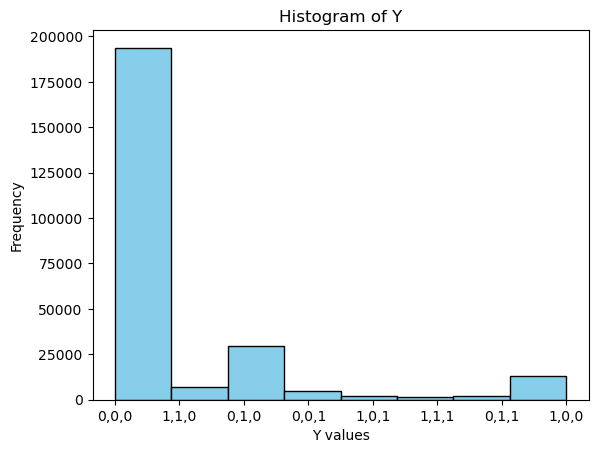

In [100]:
plt.hist(df['Y'], bins=8, color='skyblue', edgecolor='black')
plt.title('Histogram of Y')
plt.xlabel('Y values')
plt.ylabel('Frequency')
plt.show()

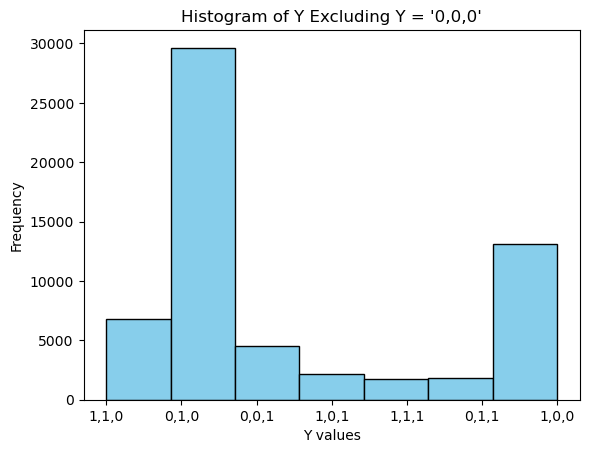

In [101]:
df_no000 = df[df['Y'] != '0,0,0']
plt.hist(df_no000['Y'], bins=7, color='skyblue', edgecolor='black')
plt.title('Histogram of Y Excluding Y = \'0,0,0\'')
plt.xlabel('Y values')
plt.ylabel('Frequency')
plt.show()

In [102]:
df['Age'].unique()

array([ 9.,  7., 11., 10.,  8., 13.,  4.,  6.,  2., 12.,  5.,  1.,  3.])

### create `Age_5Groups` column

In [103]:
def create_age_groups(age):
    if age in [1, 2, 3]:
        return 'Age(18~34)'
    elif age in [4, 5, 6]:
        return 'Age(35~49)'
    elif age in [7, 8, 9]:
        return 'Age(50~64)'
    elif age in [10, 11, 12]:
        return 'Age(65~79)'
    elif age in [13]:
        return 'Age(>=80)'
    else:
        print('Unknown value')


df['Age_5Groups'] = df['Age'].apply(create_age_groups)



In [104]:
def create_age_groups_2(age):
    if age in [1, 2]:
        return 'Young Adult(18~29)'
    elif age in [3, 4, 5]:
        return 'Middle Age(30~44)'
    elif age in [6, 7, 8, 9]:
        return 'Senior Adult(45~64)'
    elif age in [10, 11, 12, 13]:
        return 'Senior Citizens(65+)'
    else:
        print('Unknown value')


df['Age_Groups'] = df['Age'].apply(create_age_groups_2)



In [105]:
df['Age_Groups'].value_counts()

Age_Groups
Senior Adult(45~64)     110209
Senior Citizens(65+)     89070
Middle Age(30~44)        41103
Young Adult(18~29)       13298
Name: count, dtype: int64

In [106]:
df['Age_5Groups'].value_counts()

Age_5Groups
Age(50~64)    90390
Age(65~79)    71707
Age(35~49)    49799
Age(18~34)    24421
Age(>=80)     17363
Name: count, dtype: int64

In [107]:
# def one_hist(column_name):
#     group_counts = df[column_name].value_counts()

#     # index gives the name of the class
#     labels, counts = zip(*sorted(zip(group_counts.index, group_counts)))

#     plt.hist(df[column_name], bins=np.arange(len(labels)+1)-0.5, color='skyblue', edgecolor='black')

#     plt.xticks(range(len(labels)), labels, rotation=45)

#     plt.xlabel(column_name)
#     plt.ylabel('Frequency')

#     plt.show()


# Test

# Test end

# Stacked Histograms

In [108]:
def stacked_hist(df, x_var, stack_var, drop_Y000=False):
    '''
    Draws a stacked histogram for the specified variables in the dataframe.
    @df:            dataframe
    @x_var:         name of the feature on the x-axis
    @stack_var:     name of feature used to stack the histogram
    @drop_Y000:     drop the datapoints with Y = '0,0,0' 
    '''
    df_copy = df.copy()
    if drop_Y000:
        df_copy = df_copy[df_copy['Y'] != '0,0,0']
        
    stacked_data = df_copy.groupby([x_var, stack_var]).size().unstack()
    
    num_stacks = stacked_data.shape[1]
    colors = plt.cm.tab10.colors[:num_stacks]
    stacked_data.plot(kind='bar', stacked=True, color=colors, edgecolor='black')
    
    plt.xlabel(x_var)
    plt.ylabel('Frequency')
    plt.title('Stacked Histogram of ' + x_var + ' by ' + stack_var)
    plt.xticks(rotation=45)
    plt.show()



Example where we drop the datapoint with Y = 000

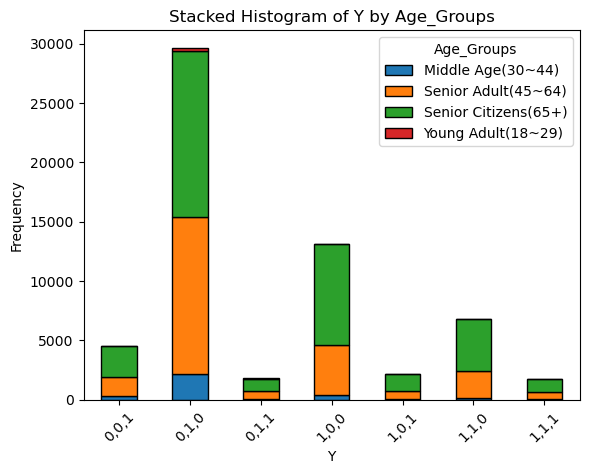

In [109]:
stacked_hist(df, 'Y', 'Age_Groups', True)

Example for the function where we want to get the histogram with respect to `Y` and use `DiffWalk` to stack

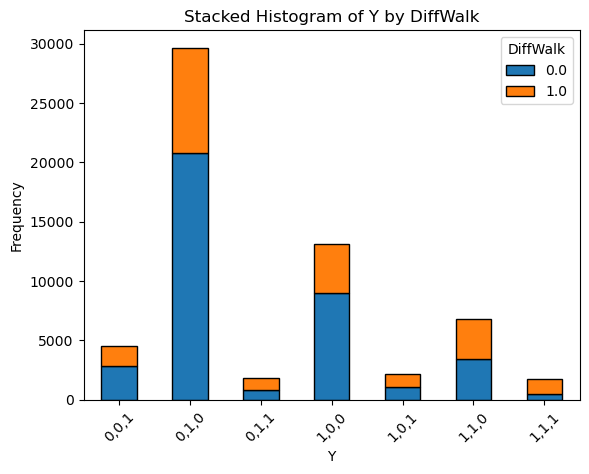

In [110]:
stacked_hist(df, 'Y', 'DiffWalk', drop_Y000=True)

## Histograms for each variable stacked on Age groups

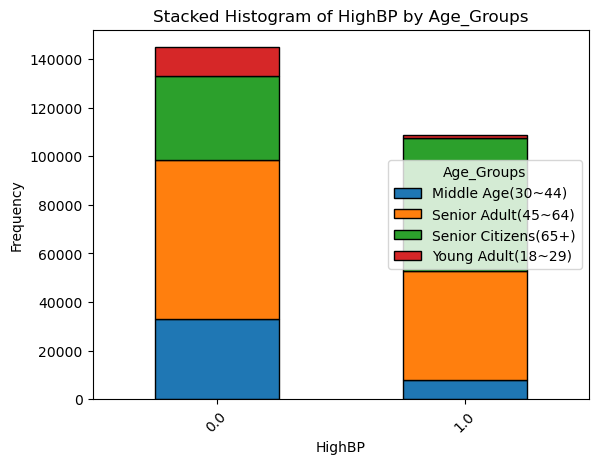

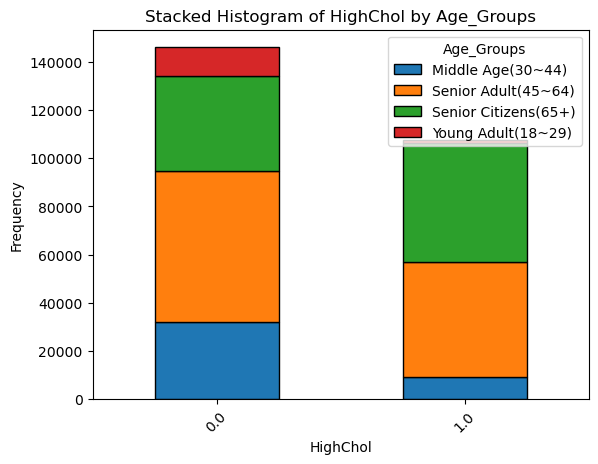

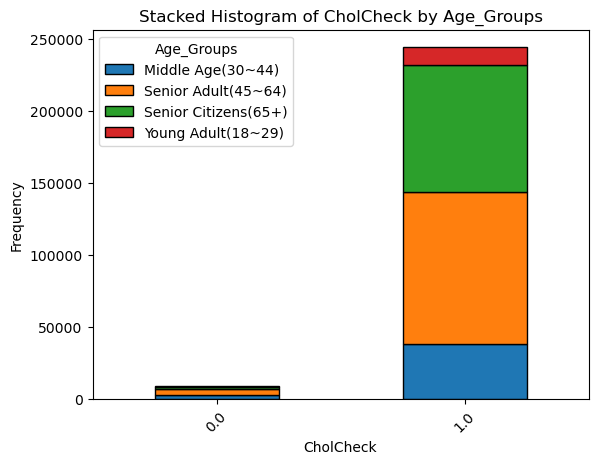

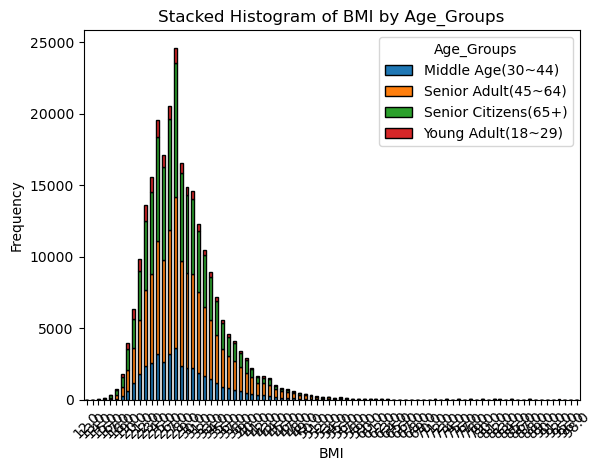

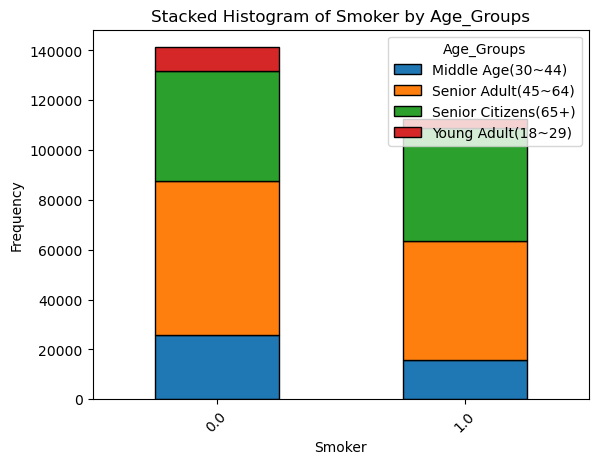

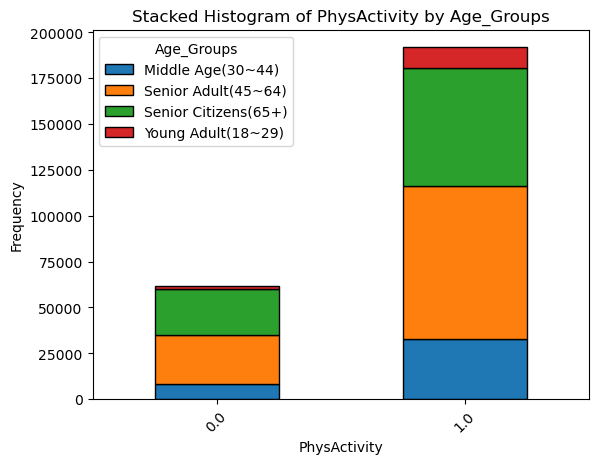

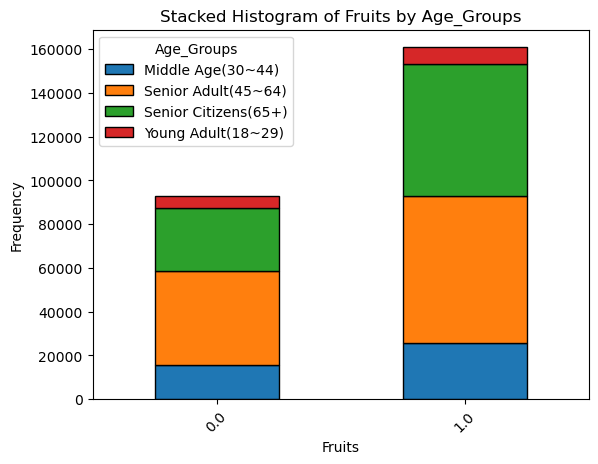

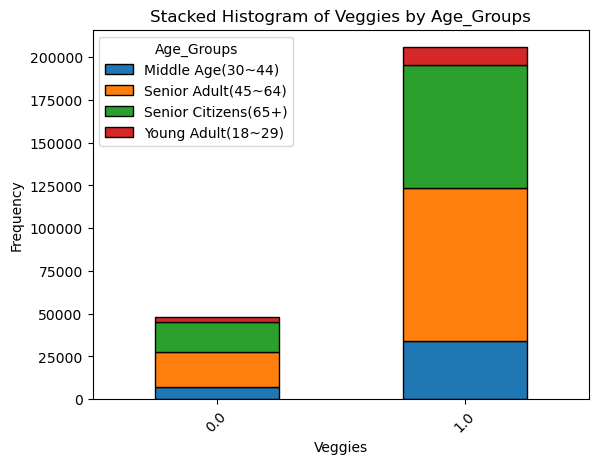

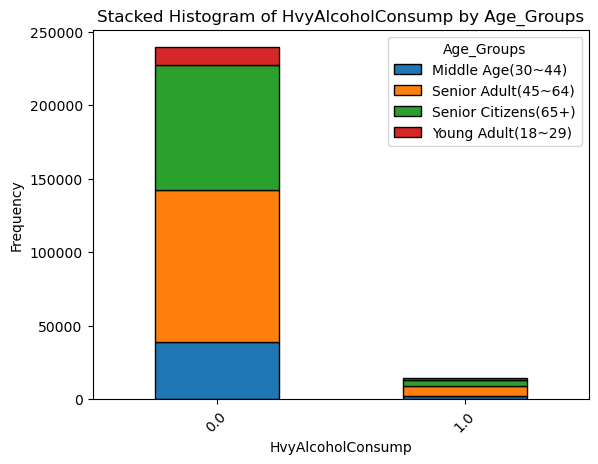

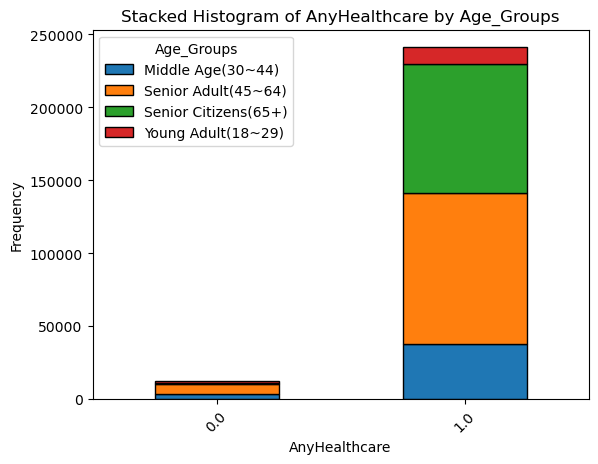

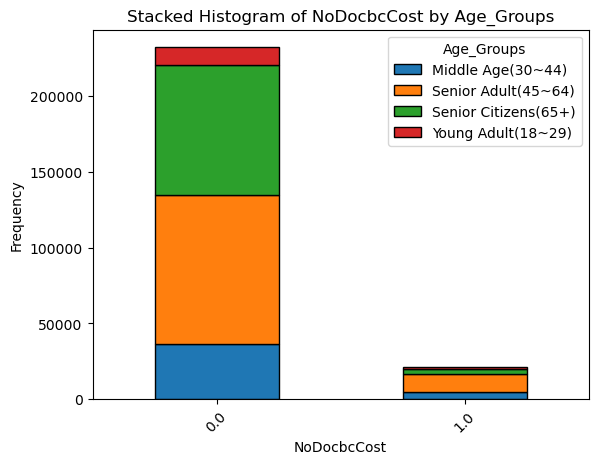

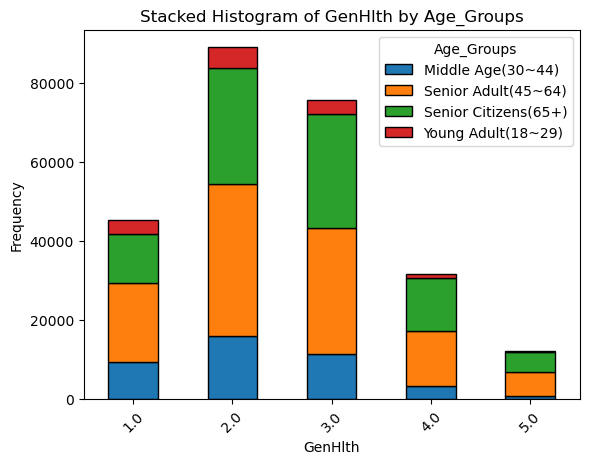

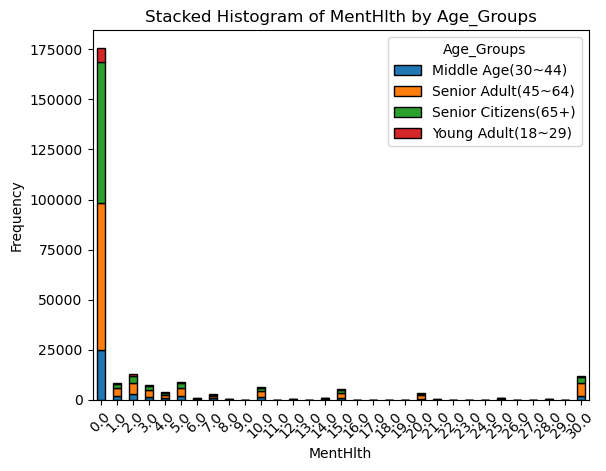

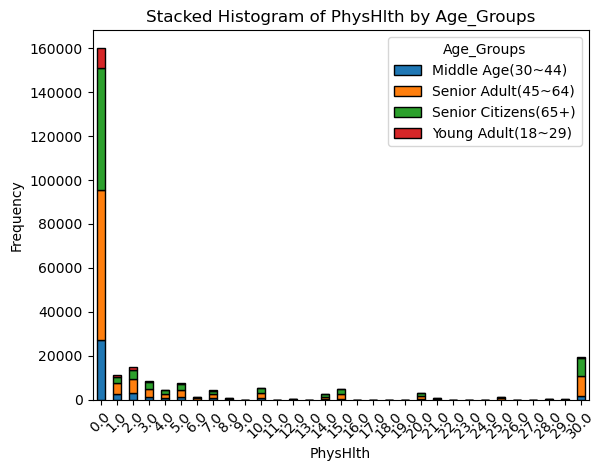

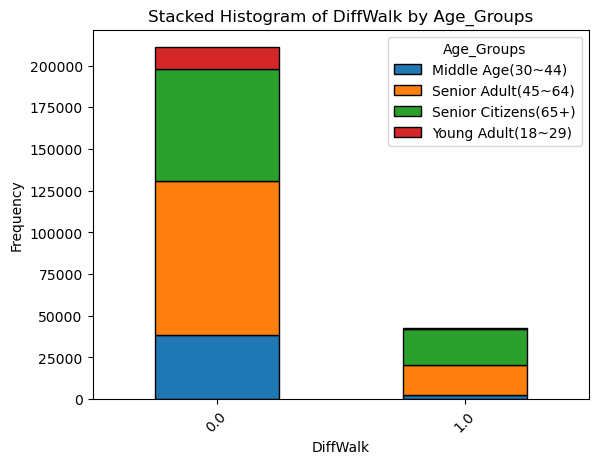

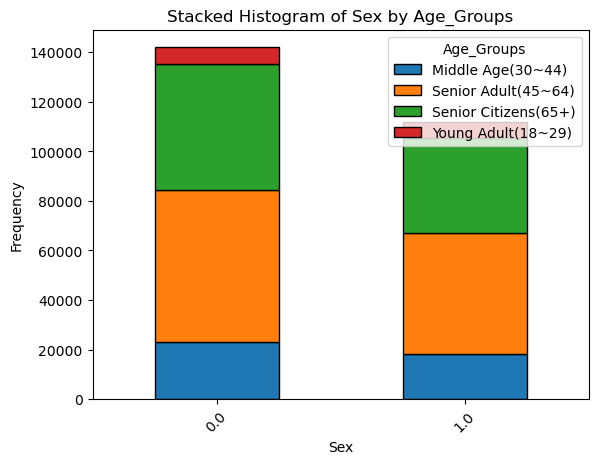

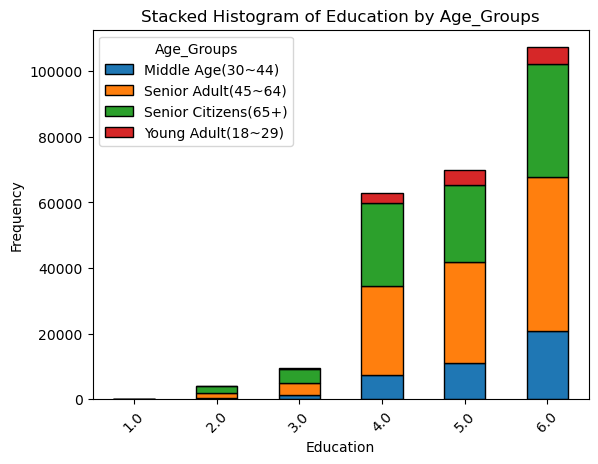

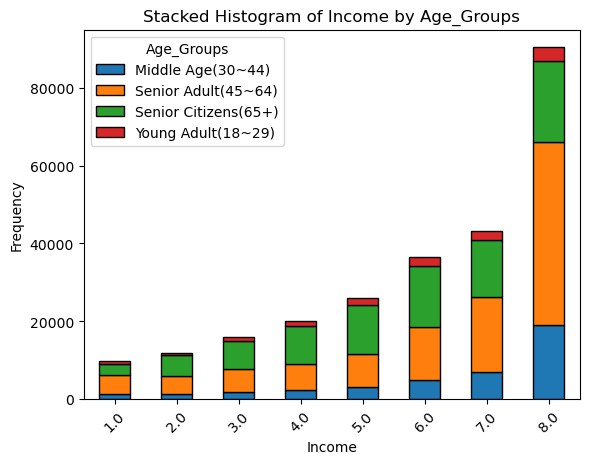

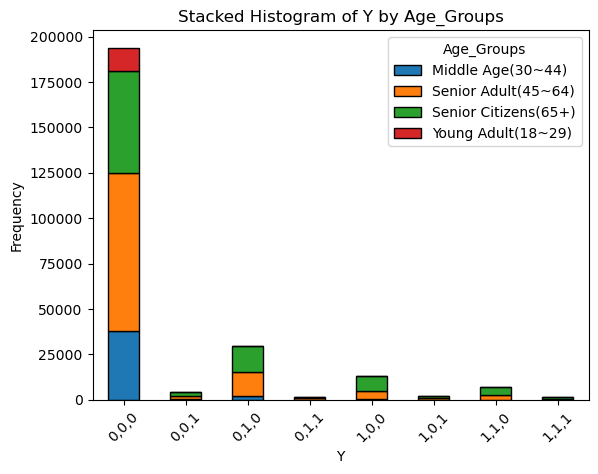

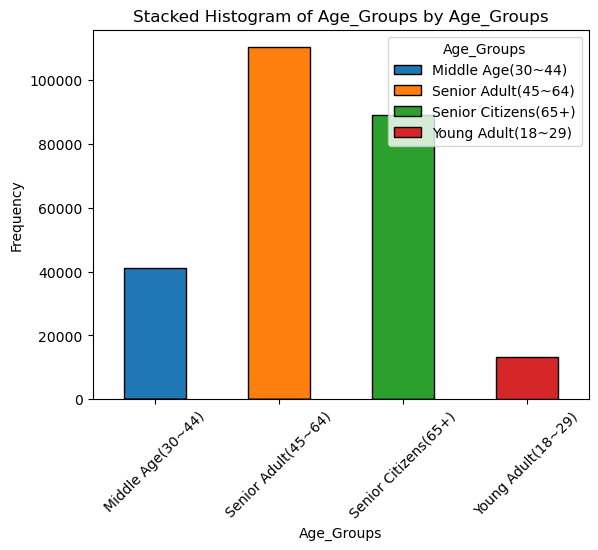

In [111]:
columns_to_drop = ['HeartDiseaseorAttack', 'Diabetes', 'Stroke', 'Age', 'Age_5Groups']
feature_names = df.drop(columns=columns_to_drop).columns
for name in feature_names:
    stacked_hist(df, name, 'Age_Groups')

# Mutual Information

### Function that calculates the mutual entropy given a column

In [112]:
##Entropy
def entropy(Y):
    if isinstance(Y, pd.Series):
        Y = Y.values

    # Handle object dtype appropriately
    if Y.dtype == object:
        # Convert array elements to string if they are not, ensures unique works correctly
        Y = np.array([str(y) for y in Y])
        
    unique, count = np.unique(Y, return_counts=True, axis=0)
    prob = count/len(Y)
    en = np.sum((-1)*prob*np.log(prob))
    return en

#Joint Entropy
def jEntropy(Y,X):
    YX = np.c_[Y,X]
    return entropy(YX)

#Conditional Entropy
def cEntropy(Y, X):
    return jEntropy(Y, X) - entropy(X)


#Information Gain
def get_mutual_information(df, Y_name, X_name, drop_Y000=False, merge_Ynot000=False):
    '''
    Calculates the mutual entropy given the name of the column
    @df:            dataframe
    @columnName:    name of the column that we want to calculate the mutual entropy for
    @drop_Y000:     drop the datapoints with Y = '0,0,0' 
    @merge_Ynot000: convert all the values in Y that is not '0,0,0' to '1,1,1'
    '''
    df_copy = df.copy()

    if drop_Y000:
        df_copy = df_copy[df_copy['Y'] != '0,0,0']

    if merge_Ynot000:
        df_copy.loc[df_copy['Y'] != '0,0,0', 'Y'] = '1,1,1'

    return entropy(df_copy[Y_name]) - cEntropy(df_copy[Y_name], df_copy[X_name])

In [113]:
get_mutual_information(df, 'Y', 'BMI')

0.03152370498739021

In [114]:
# def get_mutual_information_original(df, columnName, drop_Y000=False, merge_Ynot000=False):
#     '''
#     Calculates the mutual entropy given the name of the column
#     @df:            dataframe
#     @columnName:    name of the column that we want to calculate the mutual entropy for
#     @drop_Y000:     drop the datapoints with Y = '0,0,0' 
#     @merge_Ynot000: convert all the values in Y that is not '0,0,0' to '1,1,1'
#     '''

#     df_copy = df.copy()

#     if drop_Y000:
#         df_copy = df_copy[df_copy['Y'] != '0,0,0']

#     if merge_Ynot000:
#         df_copy.loc[df_copy['Y'] != '0,0,0', 'Y'] = '1,1,1'

#     contingency_table = pd.crosstab(df_copy[columnName], df_copy['Y'])
#     total = contingency_table.values.sum()
#     probs = contingency_table.values / total

#     conditional_entropy = sum(entropy(prob) * prob.sum() for prob in probs)

#     prob_Y = contingency_table.sum(axis=0) / total
#     entropy_Y = entropy(prob_Y)

#     mutual_information = entropy_Y - conditional_entropy
#     return mutual_information


In [115]:
columns_to_drop = ['HeartDiseaseorAttack', 'Diabetes', 'Stroke', 'Y', 'Age', 'Age_5Groups']  

#### Function that draws the Mutual Entropy graph

In [155]:
import matplotlib.pyplot as plt

def draw_mutual_information(df, columns_to_drop, byGroup=None, targetColumn='Y', topFive=False):
    '''
    Draws the Mutual Information graph(s).
    @df:                    dataframe
    @columns_to_drop:       a list of columns that we don't want to be included in the graph
    @byGroup:               the name of the column to group the data by before calculating mutual information. 
                            Each unique value in this column will result in a separate graph. If None (default), 
                            a single graph for all features is produced.
    @topFive:               if True, only the top five features with the highest mutual information are displayed
    '''
    def plot_graph(features_with_entropy, title_suffix=''):
        sorted_features_with_entropy = sorted(features_with_entropy, key=lambda x: x[1], reverse=True)
        
        if topFive:
            sorted_features_with_entropy = sorted_features_with_entropy[:5]

        sorted_feature_names, sorted_entropy_values = zip(*sorted_features_with_entropy)

        plt.figure(figsize=(10, 6))
        plt.bar(range(len(sorted_entropy_values)), sorted_entropy_values, color='skyblue')
        plt.xlabel('Features')
        plt.ylabel('Mutual Information')
        plt.title(f'Mutual Information {title_suffix}')
        plt.xticks(range(len(sorted_entropy_values)), sorted_feature_names, rotation=45)
        plt.tight_layout()

        for i, entropy_value in enumerate(sorted_entropy_values):
            plt.text(i, entropy_value, round(entropy_value, 3), ha='center', va='bottom')

        plt.show()

    if not byGroup:
        feature_names = df.drop(columns=columns_to_drop).columns
        mutual_information_list = [get_mutual_information(df, columnName, targetColumn) for columnName in feature_names]
        features_with_entropy = list(zip(feature_names, mutual_information_list))
        plot_graph(features_with_entropy, 'Overall')
    
    else:
        value_names = sorted(df[byGroup].unique())
        for value in value_names:
            df_group = df[df[byGroup] == value]
            feature_names = df_group.drop(columns=columns_to_drop).columns
            mutual_information_list = [get_mutual_information(df_group, columnName, targetColumn) for columnName in feature_names]
            features_with_entropy = list(zip(feature_names, mutual_information_list))
            plot_graph(features_with_entropy, f'for {byGroup} = {value}')


### Mutual Entropy 

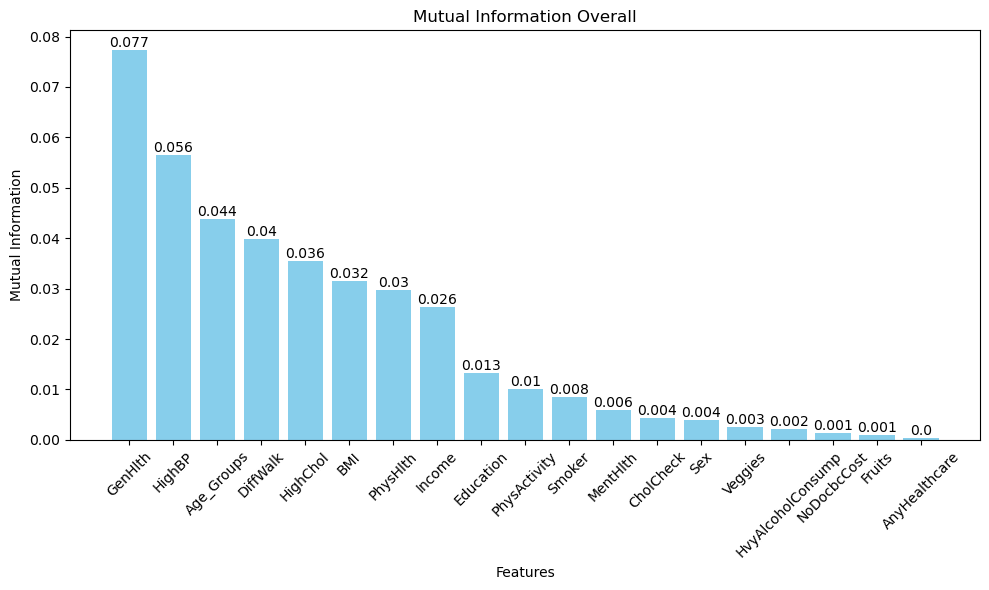

In [151]:
draw_mutual_information(df, columns_to_drop)

### Mutual Entropy from each Age group

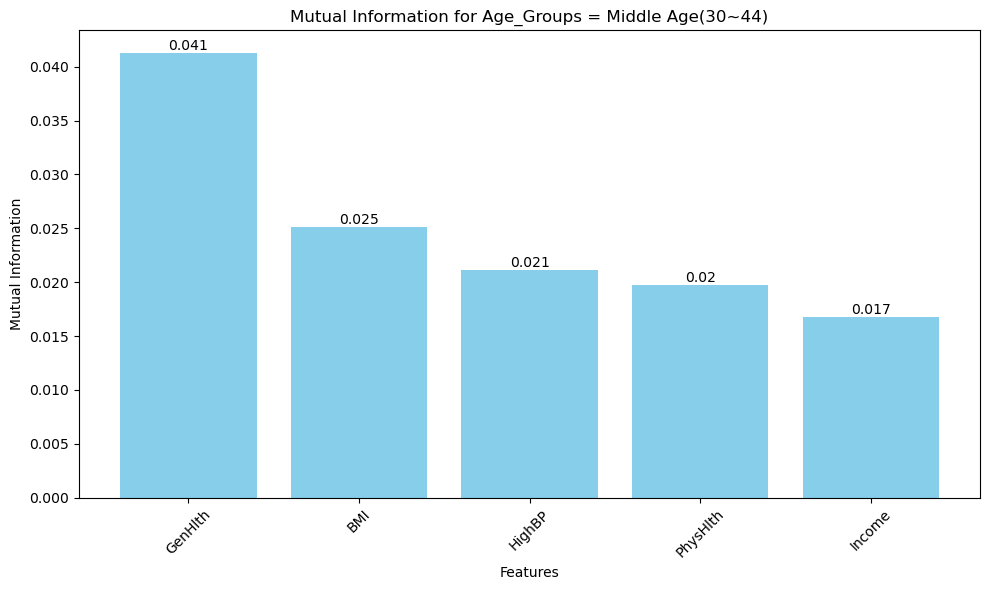

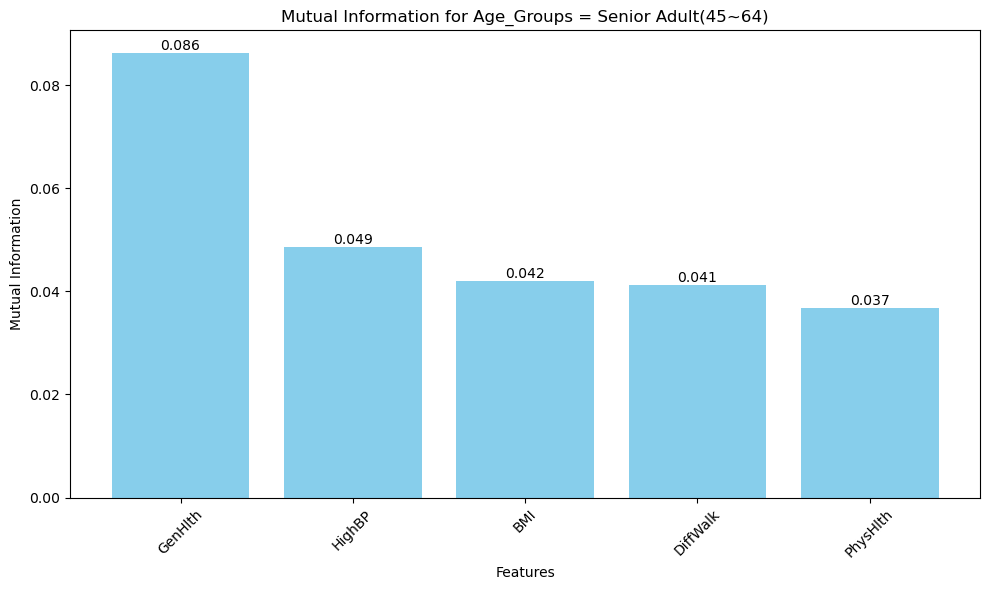

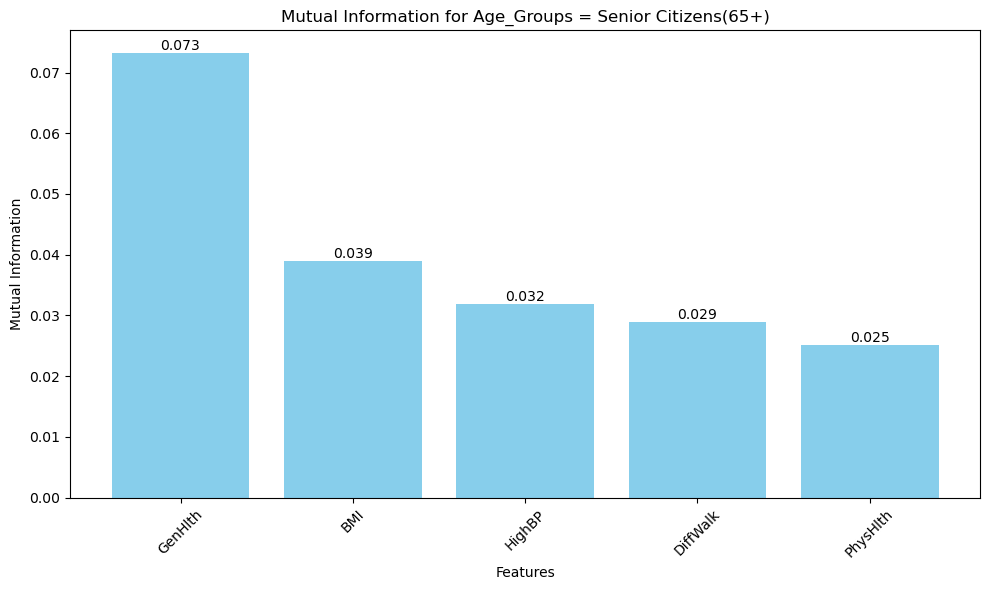

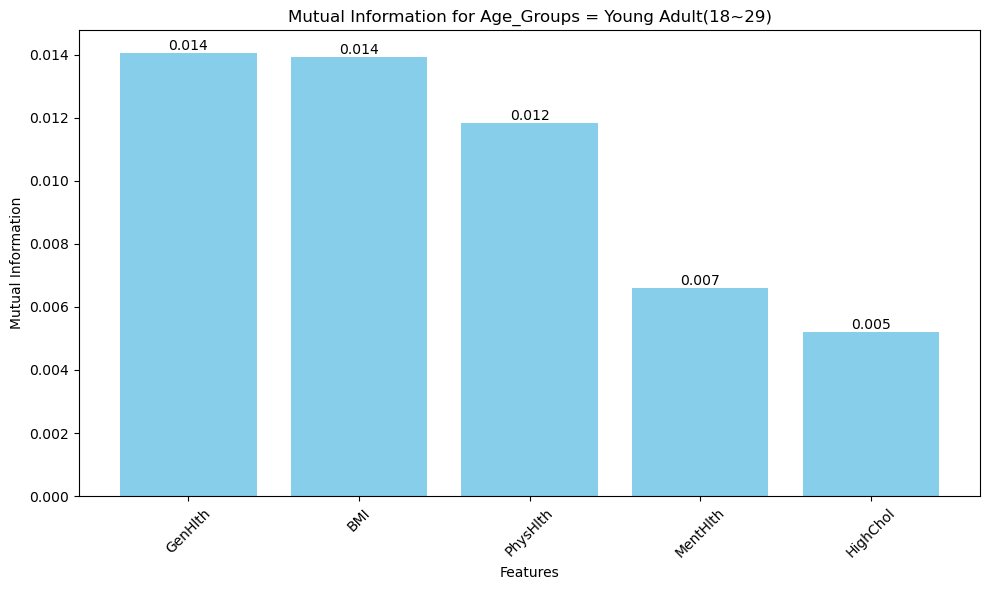

In [156]:
draw_mutual_information(df, columns_to_drop, byGroup='Age_Groups', topFive=True)

can also change the third parameter to do the graph with df grouped by different feature

Note that the mutual entropy of DiffWalk from the following 2 graphs are 0 because in each df this feature has only 1 value (either '1' or '0')

we could append the DiffWalk to columns_to_drop to ignore this feature

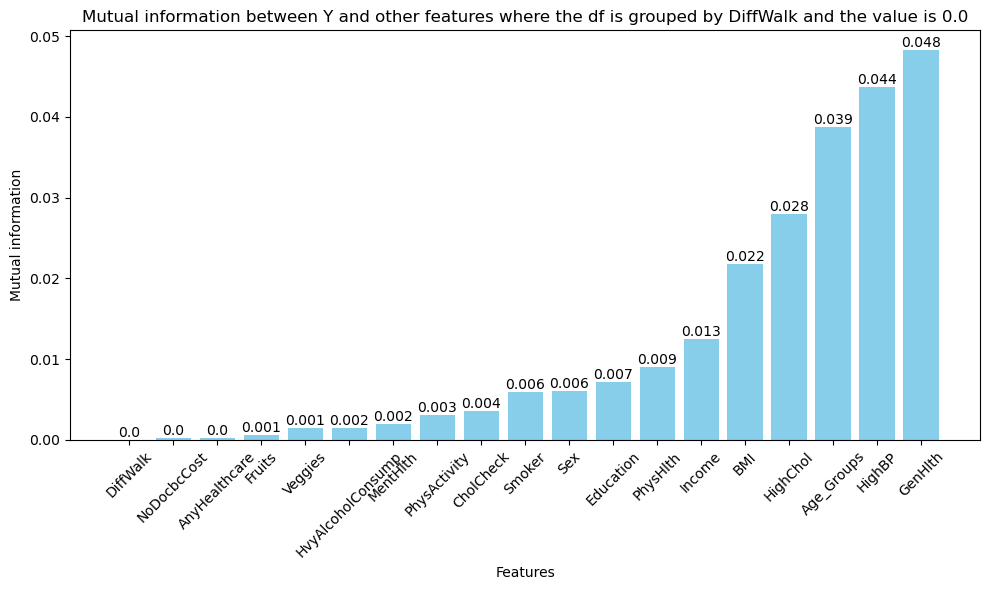

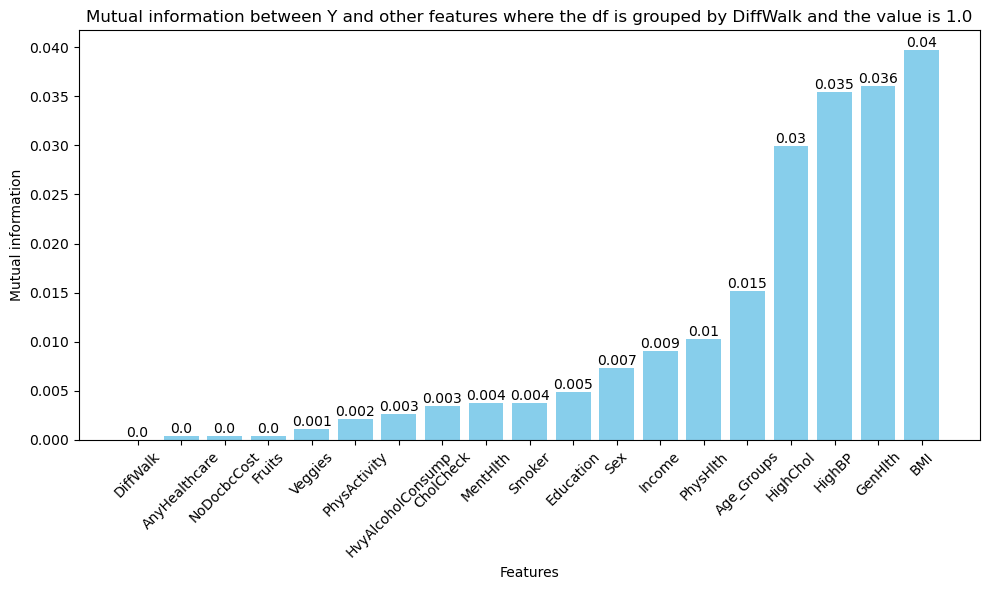

In [62]:
draw_mutual_information(df, columns_to_drop, 'DiffWalk')

The conditional entropy is used to find interaction effects.

Global view: If X=(X1,X2) as fused covariate variable, we need to compare whether 
- CE[Y]−CE[Y|X]>CE[Y]−CE[Y|X1]+CE[Y]−CE[Y|X2]

 to make sure whether the interacting effects are present.



### Define a function that merge two features

In [63]:
def merge_features(df, feature1, feature2):
    merged_series = df[feature1].astype(int).astype(str) + ',' + df[feature2].astype(int).astype(str)
    return merged_series

### Define a function that check whether an interacting effect exist between 2 features

In [64]:
def check_interac_eff(df, feature1, feature2, cache_dic=None):
    if not cache_dic:
        cache_dic = {}
    merged_feature = merge_features(df, feature1, feature2)

    if 'CE_Y' not in cache_dic:
        cache_dic['CE_Y'] = entropy(df.Y)

    CE_Y_X = cEntropy(df.Y, merged_feature)

    if feature1 not in cache_dic:
        cache_dic[feature1] = cEntropy(df.Y, df[feature1])

    if feature2 not in cache_dic:
        cache_dic[feature2] = cEntropy(df.Y, df[feature2])

    CE_Y = cache_dic['CE_Y']
    CE_Y_X1 = cache_dic[feature1]
    CE_Y_X2 = cache_dic[feature2]
    result = (CE_Y - CE_Y_X) - ((CE_Y - CE_Y_X1) + (CE_Y - CE_Y_X2))
    LHS = CE_Y - CE_Y_X
    RHS = (CE_Y - CE_Y_X1) + (CE_Y - CE_Y_X2)
    return [result, LHS, RHS]


test the function

In [65]:
cache_dic1 = {}
result= check_interac_eff(df, 'DiffWalk', 'Sex')
if result[0] > 0:
    print(f"Interacting effects exist between DiffWalk and Sex")
else:
    print('no')


Interacting effects exist between DiffWalk and Sex


sounds wield tho

## Have to run this chunk of code to run the following codes

In [66]:
columns_to_drop = ['HeartDiseaseorAttack', 'Diabetes', 'Stroke', 'Age', 'Age_5Groups', 'Age_Groups']
feature_names = df.drop(columns=columns_to_drop).columns

feature_names = feature_names.tolist()
feature_names.remove('Y')

Brute force to check all combinations:

In [68]:
from tqdm import tqdm

cache_dic = {}

n = len(feature_names)
total_iterations = n * (n - 1) / 2  
pbar = tqdm(total=total_iterations)  
interactions_list = []


for i in range(n):
    for j in range(i + 1, n):
        # print(f'Checking {feature_names[i]} & {feature_names[j]}')
        result = check_interac_eff(df, feature_names[i], feature_names[j], cache_dic)
        if result[0] > 0:
            interactions_list.append({'Feature1':feature_names[i],
                                      'Feature2':feature_names[j],
                                      'Interaction Effect':'Exist',
                                      'CE_Y - CE_Y_X':result[1],
                                      '(CE_Y - CE_Y_X1) + (CE_Y - CE_Y_X2)':result[2],
                                      'Difference':result[0]})
        else:
            interactions_list.append({'Feature1':feature_names[i],
                                      'Feature2':feature_names[j],
                                      'Interaction Effect':'Not Exist',
                                      'CE_Y - CE_Y_X':result[1],
                                      '(CE_Y - CE_Y_X1) + (CE_Y - CE_Y_X2)':result[2],
                                      'Difference':result[0]})
        pbar.update(1) 


pbar.close() 


  0%|          | 0/153.0 [11:38<?, ?it/s]
100%|██████████| 153/153.0 [12:26<00:00,  4.88s/it]


In [69]:
df_interaction = pd.DataFrame(interactions_list)
display(df_interaction)

,Feature1,Feature2,Interaction Effect,CE_Y - CE_Y_X,(CE_Y - CE_Y_X1) + (CE_Y - CE_Y_X2),Difference
0,HighBP,HighChol,Not Exist,0.073358,0.091992,-0.018634
1,HighBP,CholCheck,Not Exist,0.058560,0.060695,-0.002135
2,HighBP,BMI,Not Exist,0.076852,0.087950,-0.011098
3,HighBP,Smoker,Not Exist,0.062438,0.064857,-0.002420
4,HighBP,PhysActivity,Not Exist,0.062279,0.066436,-0.004157
...,...,...,...,...,...,...
148,DiffWalk,Education,Not Exist,0.046617,0.053098,-0.006482
149,DiffWalk,Income,Not Exist,0.051730,0.066204,-0.014473
150,Sex,Education,Exist,0.018654,0.017286,0.001367
151,Sex,Income,Exist,0.034432,0.030392,0.004040


In [70]:
df_interaction.to_csv('df_interaction.csv', index=False)
df_interaction = pd.read_csv('df_interaction.csv')

In [71]:
filtered = df_interaction[df_interaction['Interaction Effect'] == 'Exist']
top_five_diff = filtered.sort_values(by='Difference', ascending=False).head(5)
top_five_diff = top_five_diff.drop(columns=(['CE_Y - CE_Y_X', '(CE_Y - CE_Y_X1) + (CE_Y - CE_Y_X2)']))
top_five_diff

,Feature1,Feature2,Interaction Effect,Difference
56,BMI,MentHlth,Exist,0.010416
57,BMI,PhysHlth,Exist,0.008181
151,Sex,Income,Exist,0.004040
138,MentHlth,PhysHlth,Exist,0.002741
147,DiffWalk,Sex,Exist,0.002233


In [80]:
df

,Feature1,Feature2,MetricA,MetricB
0,BMI,MentHlth,4.793737,8.898743
1,BMI,PhysHlth,90.767477,5.002972
2,Sex,Income,83.180443,9.921422
3,MentHlth,PhysHlth,22.782732,4.111834
4,DiffWalk,Sex,41.959100,7.783149


In [ ]:

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.graphics.factorplots import interaction_plot


In [72]:
filtered = df_interaction[df_interaction['Interaction Effect'] == 'Exist']
top_five_RHS = filtered.sort_values(by='CE_Y - CE_Y_X', ascending=False).head(5)
top_five_RHS = top_five_RHS.drop(columns=(['Difference', '(CE_Y - CE_Y_X1) + (CE_Y - CE_Y_X2)']))
top_five_RHS

,Feature1,Feature2,Interaction Effect,CE_Y - CE_Y_X
135,GenHlth,Sex,Exist,0.082572
118,AnyHealthcare,GenHlth,Exist,0.078406
57,BMI,PhysHlth,Exist,0.069471
61,BMI,Income,Exist,0.059994
7,HighBP,HvyAlcoholConsump,Exist,0.058760


### Implement Contigency Table or something else below

# Contingency Table

In [73]:
def con_table(df, feature1, feature2='Y', prob=False, odd=False):
    contingency_table = pd.crosstab(df[feature1], df[feature2])
    print("Contingency Table:")
    display(contingency_table)

    if prob:
        print("\nProbability Table:")
        probability_table = contingency_table.div(contingency_table.sum(axis=1), axis=0)
        
        display(probability_table)
    
    # if odd:
    #     if not prob:
    #         probability_table = contingency_table.div(contingency_table.sum(axis=1), axis=0)
        
    #     # odd = P(A) / (1 - P(A))
    #     odds_table = probability_table.div(probability_table)
    #     print("\nOdds Table:")
    #     display(odds_table)


       

In [74]:
con_table(df, 'Sex', 'HighBP', prob=True, odd=True)

Contingency Table:


HighBP,0.0,1.0
Sex,,
0.0,84321,57653
1.0,60530,51176



Probability Table:


HighBP,0.0,1.0
Sex,,
0.0,0.593919,0.406081
1.0,0.541869,0.458131
